In [ ]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

#Leitura e Limpeza dos Dados
A leitura dos dados é feita utilizando a biblioteca pandas. O presente exemplo importa a base de dados mammography. Caso você esteja trabalhando com outro data set, modifique este trecho de código. Para importar o conjunto de dados do PAKDD, use a função pd.read_table ao invés da pd.read_csv.

In [2]:
data_set = pd.read_csv('mammography.csv')
data_set.drop_duplicates(inplace=True)  # Remove exemplos repetidos

In [3]:
X = data_set.iloc[:, :-1].values
y = data_set.iloc[:, -1].values
y = np.where(y == -1, 0, 1)

In [4]:
## Treino: 50%, Validação: 25%, Teste: 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, 
                                                    random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/3, 
                                                  random_state=42, stratify=y_train)

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [6]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

# Agora adicionamos a primeira camada escondida contendo 16 neurônios e função de ativação
# tangente hiperbólica. Por ser a primeira camada adicionada à rede, precisamos especificar
# a dimensão de entrada (número de features do data set), que no caso do mammography são 6.
classifier.add(Dense(16, activation='tanh', input_dim=6))

# Em seguida adicionamos a camada de saída. Como nosso problema é binário só precisamos de
# 1 neurônio com função de ativação sigmoidal. A partir da segunda camada adicionada keras já
# consegue inferir o número de neurônios de entrada (16) e nós não precisamos mais especificar.
classifier.add(Dense(1, activation='sigmoid'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
classifier.compile(optimizer='adam', loss='mean_squared_error')


In [7]:
# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No presente exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train, batch_size=64, epochs=100000, 
                         callbacks=[EarlyStopping()], validation_data=(X_val, y_val))


Train on 3924 samples, validate on 1962 samples
Epoch 1/100000
3924/3924 [==============================] - 0s - loss: 0.2153 - val_loss: 0.1768
Epoch 2/100000
3924/3924 [==============================] - 0s - loss: 0.1473 - val_loss: 0.1211
Epoch 3/100000
3924/3924 [==============================] - 0s - loss: 0.0973 - val_loss: 0.0787
Epoch 4/100000
3924/3924 [==============================] - 0s - loss: 0.0630 - val_loss: 0.0526
Epoch 5/100000
3924/3924 [==============================] - 0s - loss: 0.0435 - val_loss: 0.0389
Epoch 6/100000
3924/3924 [==============================] - 0s - loss: 0.0333 - val_loss: 0.0316
Epoch 7/100000
3924/3924 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0276
Epoch 8/100000
3924/3924 [==============================] - 0s - loss: 0.0244 - val_loss: 0.0251
Epoch 9/100000
3924/3924 [==============================] - 0s - loss: 0.0223 - val_loss: 0.0235
Epoch 10/100000
3924/3924 [==============================] - 0s - loss: 0.0208 

In [8]:
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

<IPython.core.display.Javascript object>


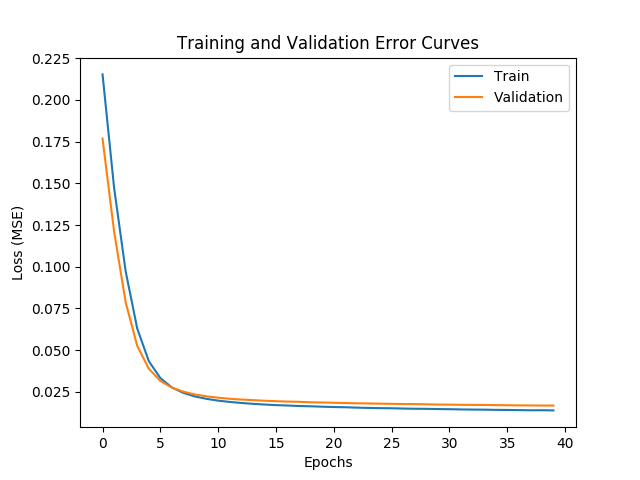

In [9]:
plot_training_error_curves(history)

In [10]:
## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

Matriz de confusão
[[1886   13]
 [  36   28]]

Train Loss:       0.0140
Validation Loss:  0.0168
Accuracy:         0.9750
Recall:           0.4375
Precision:        0.6829
F1:               0.5333
AUROC:            0.9259
